In [2]:
# Import tensorflow and pyplot
import tensorflow as tf
import matplotlib.pyplot as plt

1. tf.Graph represents a collection of tf.Operations
2. You can create operations by writing out equations.
3. By default, there is a graph: tf.get_default_graph() and any new operations are added to this graph.
4. The result of a tf.Operation is a tf.Tensor, which holds the values.

In [3]:
# First a tf.Tensor
n_values = 32
x = tf.linspace(-3.0, 3.0, n_values)

In [4]:
# Construct a tf.Session to execute the graph.
sess = tf.Session()
result = sess.run(x)

In [5]:
# Alternatively pass a session to the eval fn:
x.eval(session=sess)
# x.eval() does not work, as it requires a session!

array([-3.        , -2.80645156, -2.61290312, -2.41935492, -2.22580647,
       -2.03225803, -1.83870971, -1.64516139, -1.45161295, -1.25806451,
       -1.06451619, -0.87096786, -0.67741942, -0.48387098, -0.29032278,
       -0.09677434,  0.0967741 ,  0.29032254,  0.48387098,  0.67741919,
        0.87096763,  1.06451607,  1.25806427,  1.45161295,  1.64516115,
        1.83870935,  2.03225803,  2.22580624,  2.41935444,  2.61290312,
        2.80645132,  3.        ], dtype=float32)

In [6]:
# We can setup an interactive session if we don't
# want to keep passing the session around:
sess.close()
sess = tf.InteractiveSession()

In [8]:
# Now this will work!
x.eval()

array([-3.        , -2.80645156, -2.61290312, -2.41935492, -2.22580647,
       -2.03225803, -1.83870971, -1.64516139, -1.45161295, -1.25806451,
       -1.06451619, -0.87096786, -0.67741942, -0.48387098, -0.29032278,
       -0.09677434,  0.0967741 ,  0.29032254,  0.48387098,  0.67741919,
        0.87096763,  1.06451607,  1.25806427,  1.45161295,  1.64516115,
        1.83870935,  2.03225803,  2.22580624,  2.41935444,  2.61290312,
        2.80645132,  3.        ], dtype=float32)

In [27]:
# Now a tf.Operation
# We'll use our values from [-3, 3] to create a Gaussian Distribution
sigma = 1.0
mean = 0.0
z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0)/(2.0 * tf.pow(sigma, 2.0)))) *(1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))

In [28]:
# By default, new operations are added to the default Graph
assert z.graph is tf.get_default_graph()



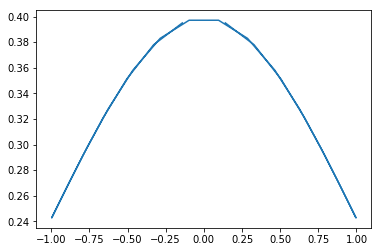

In [29]:
# Execute the graph and plot the result
plt.plot(x.eval(), z.eval())
plt.show()

In [30]:
# We can find out the shape of a tensor like so:
print(z.get_shape())

(32, 1)


In [31]:
# Or in a more friendly format
print(z.get_shape().as_list())

[32, 1]


In [32]:
#Sometimes we may not know the shape of a tensor
# until it is computed in the graph.  In that case
# we should use the tf.shape fn, which will return a
# Tensor which can be eval'ed, rather than a discrete
# value of tf.Dimension
print(tf.shape(z).eval())

[32  1]


In [33]:
# %% Let's multiply the two to get a 2d gaussian
z_2d = tf.matmul(tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))

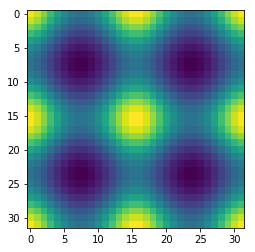

In [34]:
plt.imshow(z_2d.eval())
plt.show()

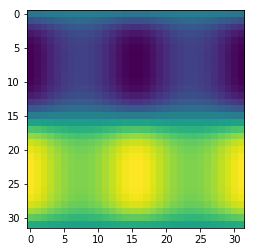

In [35]:
x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
y = tf.reshape(tf.ones_like(x), [1, n_values])
z = tf.multiply(tf.matmul(x, y), z_2d)
plt.imshow(z.eval())
plt.show()

In [ ]:
# We can also list all the operations of a graph:
ops = tf.get_default_graph().get_operations()
print([op.name for op in ops])
# run this yourself, some nasty values emerges here.

In [43]:
# Lets try creating a generic function for computing the same thing:
def gabor(n_values=32, sigma=1.0, mean=0.0):
    x = tf.linspace(-3.0, 3.0, n_values)
    z = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                       (2.0 * tf.pow(sigma, 2.0)))) *
         (1.0 / (sigma * tf.sqrt(2.0 * 3.1415))))
    gauss_kernel = tf.matmul(
        tf.reshape(z, [n_values, 1]), tf.reshape(z, [1, n_values]))
    x = tf.reshape(tf.sin(tf.linspace(-3.0, 3.0, n_values)), [n_values, 1])
    y = tf.reshape(tf.ones_like(x), [1, n_values])
    gabor_kernel = tf.multiply(tf.matmul(x, y), gauss_kernel)
    return gabor_kernel

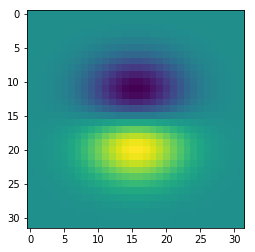

In [44]:
# Lets's plot
plt.imshow(gabor().eval())
plt.show()

In [45]:
# And another function which can convolve
def convolve(img, W):
    # The W matrix is only 2D
    # But conv2d will need a tensor which is 4d:
    # height x width x n_input x n_output
    if len(W.get_shape()) == 2:
        dims = W.get_shape().as_list() + [1, 1]
        W = tf.reshape(W, dims)

    if len(img.get_shape()) == 2:
        # num x height x width x channels
        dims = [1] + img.get_shape().as_list() + [1]
        img = tf.reshape(img, dims)
    elif len(img.get_shape()) == 3:
        dims = [1] + img.get_shape().as_list()
        img = tf.reshape(img, dims)
        # if the image is 3 channels, then our convolution
        # kernel needs to be repeated for each input channel
        W = tf.concat(2, [W, W, W])

    # Stride is how many values to skip for the dimensions of
    # num, height, width, channels
    convolved = tf.nn.conv2d(img, W,
                             strides=[1, 1, 1, 1], padding='SAME')
    return convolved


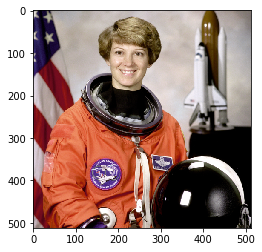

(512, 512, 3)


In [47]:
# Load up an image:
from skimage import data
img = data.astronaut()
plt.imshow(img)
plt.show()
print(img.shape)